In [15]:
import numpy as np
import pandas as pd
import plotly.express as px
from scipy import stats
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
import seaborn as sns

In [16]:
df = pd.read_csv('lag_data.csv',  delimiter=';')
df.head()


,doi,API,cof1,ratio_mole,liquid,liq_amount_mL,mixing_apparatus,mixing_frequency_Hz,mixing_temp_C,mixing_time_min,drying_time_hour,drying_temp_C,text
0,10.1016/j.ejps.2015.05.017,Caffeine,citric acid,4:1,water,0.3,"planetary mill (Pulverisette 7; Fritsch GmbH, ...",NaN,NaN,NaN,NaN,NaN,LAG experiments with CF and CTA were performed...
1,10.1016/j.ejps.2015.05.017,Caffeine,citric acid,3:1,water,0.3,"planetary mill (Pulverisette 7; Fritsch GmbH, ...",NaN,NaN,NaN,NaN,NaN,NaN
2,10.1016/j.ejps.2015.05.017,Caffeine,citric acid,2:1,water,0.3,"planetary mill (Pulverisette 7; Fritsch GmbH, ...",NaN,NaN,NaN,NaN,NaN,NaN
3,10.1016/j.ejps.2015.05.017,Caffeine,citric acid,1:1,water,0.3,"planetary mill (Pulverisette 7; Fritsch GmbH, ...",NaN,NaN,NaN,NaN,NaN,NaN
4,10.1016/j.ejps.2015.05.017,Caffeine,citric acid,1:2,water,0.3,"planetary mill (Pulverisette 7; Fritsch GmbH, ...",NaN,NaN,NaN,NaN,NaN,NaN


**Описание таблицы:**

1. doi статьи
2. API - активный фармацевтический компонент
3. cof1 - коформер (в процессе сбора информации приняла решение использовать  только двоичные системы)
4. ratio, mol - молярное соотношение API к cof1
5. liquid - растворитель
6. liq_amount_mL - объем растворителя, миллилитры
7. mixing apparatus - смешивающий аппарат
8. mixing frequency, Hz - частота перемешивания, герц
9. mixing temp, C - температура перемешивания, градусы Цельсия
10. mixing time, min - время перемешивания, минуты
11. drying time, h - время сушки, часы
12. drying temp, C - температура сушки, градусы Цельсия
13. text - текст методики синтеза

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   doi                  119 non-null    object 
 1   API                  119 non-null    object 
 2   cof1                 119 non-null    object 
 3   ratio_mole           119 non-null    object 
 4   liquid               119 non-null    object 
 5   liq_amount_mL        47 non-null     float64
 6   mixing_apparatus     60 non-null     object 
 7   mixing_frequency_Hz  20 non-null     float64
 8   mixing_temp_C        1 non-null      float64
 9   mixing_time_min      71 non-null     float64
 10  drying_time_hour     9 non-null      float64
 11  drying_temp_C        14 non-null     float64
 12  text                 18 non-null     object 
dtypes: float64(6), object(7)
memory usage: 12.3+ KB


In [23]:
#Удаляем столбец с текестом методики, в данной работе он не понадобится

df = df.drop(columns = ['text'])

В нашем датасете много пропусков значений (в статьях не всегда указывается полный необходимый перечень параметров), поэтому заполним пропуски

In [24]:
#Проверим количество пропусков в каждом столбце

df.isna().sum()

doi                      1
API                      1
cof1                     1
ratio_mole               1
liquid                   1
liq_amount_mL           73
mixing_apparatus        60
mixing_frequency_Hz    100
mixing_temp_C          119
mixing_time_min         49
drying_time_hour       111
drying_temp_C          106
dtype: int64

In [25]:
df = df.dropna(subset=['doi'])

В нашем случае, исследователи часто не указывает параметр  если он является СТАНДАРТНЫМ, некоторые из них мы можем заполнить.

In [26]:
df.fillna({'mixing_temp_C': 20}, inplace=True) #Температуры меняем на стандартные

df.fillna({'drying_temp_C': 20}, inplace=True)

Нередко в статьях могут указывать объем жидкости в каплях или не указывать вовсе, имея в виду капли, расчет точного объема капли каждого растворителя требует большого количества сложных расчетов, а также является невозможнным, поскольку необходимо учитывать диаметр носика бюретки, который, **естественно**, не пишут

In [27]:
df.fillna({'liq_amount_mL': 0.1}, inplace=True) 

In [28]:
#Ступка и пестик - самый доступный метод измельчения в лаборатории, был бы у них прибор, они бы написали..

df['mixing_apparatus '] = df['mixing_apparatus '].fillna('mortar and pestle')

In [29]:
df.fillna({'mixing_time_min': df['mixing_time_min'].mean()}, inplace=True)
df.fillna({'drying_time_hour': df['drying_time_hour'].mean()}, inplace=True)

In [30]:
#Частота перемешивания не имеет особого влияния при использовании ступки с пестиком, поэтому заменяем пустые значения на ноль
#Но частота вращения важна при применении мельниц, заменим на среднее значение частоты

df_copy = df

def replace_values(row):
    if pd.isna(row['mixing_frequency_Hz']):  
        if 'mortar and pestle' in row['mixing_apparatus ']: 
            return 1
        else:
            return 39.23
    return row['mixing_frequency_Hz'] 

df_copy['mixing_frequency_Hz'] = df.apply(replace_values, axis=1)
df_copy

,doi,API,cof1,ratio_mole,liquid,liq_amount_mL,mixing_apparatus,mixing_frequency_Hz,mixing_temp_C,mixing_time_min,drying_time_hour,drying_temp_C
0,10.1016/j.ejps.2015.05.017,Caffeine,citric acid,4:1,water,0.3,"planetary mill (Pulverisette 7; Fritsch GmbH, ...",39.23,20.0,39.225352,32.222222,20.0
1,10.1016/j.ejps.2015.05.017,Caffeine,citric acid,3:1,water,0.3,"planetary mill (Pulverisette 7; Fritsch GmbH, ...",39.23,20.0,39.225352,32.222222,20.0
2,10.1016/j.ejps.2015.05.017,Caffeine,citric acid,2:1,water,0.3,"planetary mill (Pulverisette 7; Fritsch GmbH, ...",39.23,20.0,39.225352,32.222222,20.0
3,10.1016/j.ejps.2015.05.017,Caffeine,citric acid,1:1,water,0.3,"planetary mill (Pulverisette 7; Fritsch GmbH, ...",39.23,20.0,39.225352,32.222222,20.0
4,10.1016/j.ejps.2015.05.017,Caffeine,citric acid,1:2,water,0.3,"planetary mill (Pulverisette 7; Fritsch GmbH, ...",39.23,20.0,39.225352,32.222222,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...
114,https://doi.org/10.1016/j.matpr.2019.03.069,betulin,succinic acid,1:1,dioxan,1.0,mortar and pestle,1.00,20.0,39.225352,32.222222,20.0
115,https://doi.org/10.1016/j.matpr.2019.03.069,betulin,suberic acid,1:1,dioxan,1.0,mortar and pestle,1.00,20.0,39.225352,32.222222,20.0
116,https://doi.org/10.1016/j.ijpharm.2022.122283,hydrochlorothiazide,nicotinamide,1:1,ethanol,0.1,mortar and pestle,1.00,20.0,39.225352,8.000000,40.0
117,https://doi.org/10.1016/j.ijpharm.2022.122283,hydrochlorothiazide,succinimide,1:1,ethanol,0.1,mortar and pestle,1.00,20.0,39.225352,8.000000,40.0


In [31]:
df = df_copy

In [32]:
df

,doi,API,cof1,ratio_mole,liquid,liq_amount_mL,mixing_apparatus,mixing_frequency_Hz,mixing_temp_C,mixing_time_min,drying_time_hour,drying_temp_C
0,10.1016/j.ejps.2015.05.017,Caffeine,citric acid,4:1,water,0.3,"planetary mill (Pulverisette 7; Fritsch GmbH, ...",39.23,20.0,39.225352,32.222222,20.0
1,10.1016/j.ejps.2015.05.017,Caffeine,citric acid,3:1,water,0.3,"planetary mill (Pulverisette 7; Fritsch GmbH, ...",39.23,20.0,39.225352,32.222222,20.0
2,10.1016/j.ejps.2015.05.017,Caffeine,citric acid,2:1,water,0.3,"planetary mill (Pulverisette 7; Fritsch GmbH, ...",39.23,20.0,39.225352,32.222222,20.0
3,10.1016/j.ejps.2015.05.017,Caffeine,citric acid,1:1,water,0.3,"planetary mill (Pulverisette 7; Fritsch GmbH, ...",39.23,20.0,39.225352,32.222222,20.0
4,10.1016/j.ejps.2015.05.017,Caffeine,citric acid,1:2,water,0.3,"planetary mill (Pulverisette 7; Fritsch GmbH, ...",39.23,20.0,39.225352,32.222222,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...
114,https://doi.org/10.1016/j.matpr.2019.03.069,betulin,succinic acid,1:1,dioxan,1.0,mortar and pestle,1.00,20.0,39.225352,32.222222,20.0
115,https://doi.org/10.1016/j.matpr.2019.03.069,betulin,suberic acid,1:1,dioxan,1.0,mortar and pestle,1.00,20.0,39.225352,32.222222,20.0
116,https://doi.org/10.1016/j.ijpharm.2022.122283,hydrochlorothiazide,nicotinamide,1:1,ethanol,0.1,mortar and pestle,1.00,20.0,39.225352,8.000000,40.0
117,https://doi.org/10.1016/j.ijpharm.2022.122283,hydrochlorothiazide,succinimide,1:1,ethanol,0.1,mortar and pestle,1.00,20.0,39.225352,8.000000,40.0


In [33]:
df.isna().sum()

doi                    0
API                    0
cof1                   0
ratio_mole             0
liquid                 0
liq_amount_mL          0
mixing_apparatus       0
mixing_frequency_Hz    0
mixing_temp_C          0
mixing_time_min        0
drying_time_hour       0
drying_temp_C          0
dtype: int64

Все пропуски заполнены, теперь можно будет приступать к анализу базы данных!

In [34]:
#Описание численных признаков
df.describe()

,liq_amount_mL,mixing_frequency_Hz,mixing_temp_C,mixing_time_min,drying_time_hour,drying_temp_C
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000
mean,0.173529,8.681261,20.084034,39.225352,32.222222,22.857143
std,0.169848,13.800205,0.916698,6.939444,20.382893,11.228962
min,0.100000,1.000000,20.000000,25.000000,0.500000,20.000000
25%,0.100000,1.000000,20.000000,39.225352,32.222222,20.000000
50%,0.100000,1.000000,20.000000,39.225352,32.222222,20.000000
75%,0.250000,1.000000,20.000000,45.000000,32.222222,20.000000
max,1.000000,39.230000,30.000000,45.000000,240.000000,80.000000


Анализ распределения объема растворителя

In [35]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Распределение объема растворителя', 'Violin Plot для растворителя'])

# Гистограмма
hist_fig = px.histogram(df, x="liq_amount_mL", nbins = 60,
                 color_discrete_sequence = ["orange", "red", "green"])

fig.add_trace(hist_fig['data'][0], row=1, col=1) # Добавление графика с указанием расположения

# Violin plot
violin_fig = px.violin(df, y="liq_amount_mL", color_discrete_sequence = ["blue", "purple"], box = True)  
fig.add_trace(violin_fig['data'][0], row=1, col=2) # Добавление графика с указанием расположения

# Настройка макета
fig.update_layout(showlegend=False, title_text="Гистограмма и Violin Plot") 

# Отображение графика
fig.show()

Распределение совсем не похоже на нормальное, но видно, что в большинстве экспериментов использовали именно капли.

Все-таки проверим это распределение.

In [36]:
# Проведем тест Андерсона-Дарлинга на нормальность
#В параметре dist указываем необходимое нам распределение - нормальное
result = stats.anderson(df['liq_amount_mL'], dist='norm')

print(f"Результат теста: {result}")

print('Статистика теста:', result.statistic)
print('Критические значения:', result.critical_values)

print('Уровень значимости:', result.significance_level)

if result.statistic < result.critical_values[2]:
    print("Данные похожи на нормальное распределение (гипотеза о нормальности не отвергается).")
else:
    print("Данные не похожи на нормальное распределение (гипотеза о нормальности отвергается).")

Результат теста: AndersonResult(statistic=21.168545835354365, critical_values=array([0.558, 0.636, 0.763, 0.89 , 1.058]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.17352941176470593, scale=0.16984832832881142)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Статистика теста: 21.168545835354365
Критические значения: [0.558 0.636 0.763 0.89  1.058]
Уровень значимости: [15.  10.   5.   2.5  1. ]
Данные не похожи на нормальное распределение (гипотеза о нормальности отвергается).


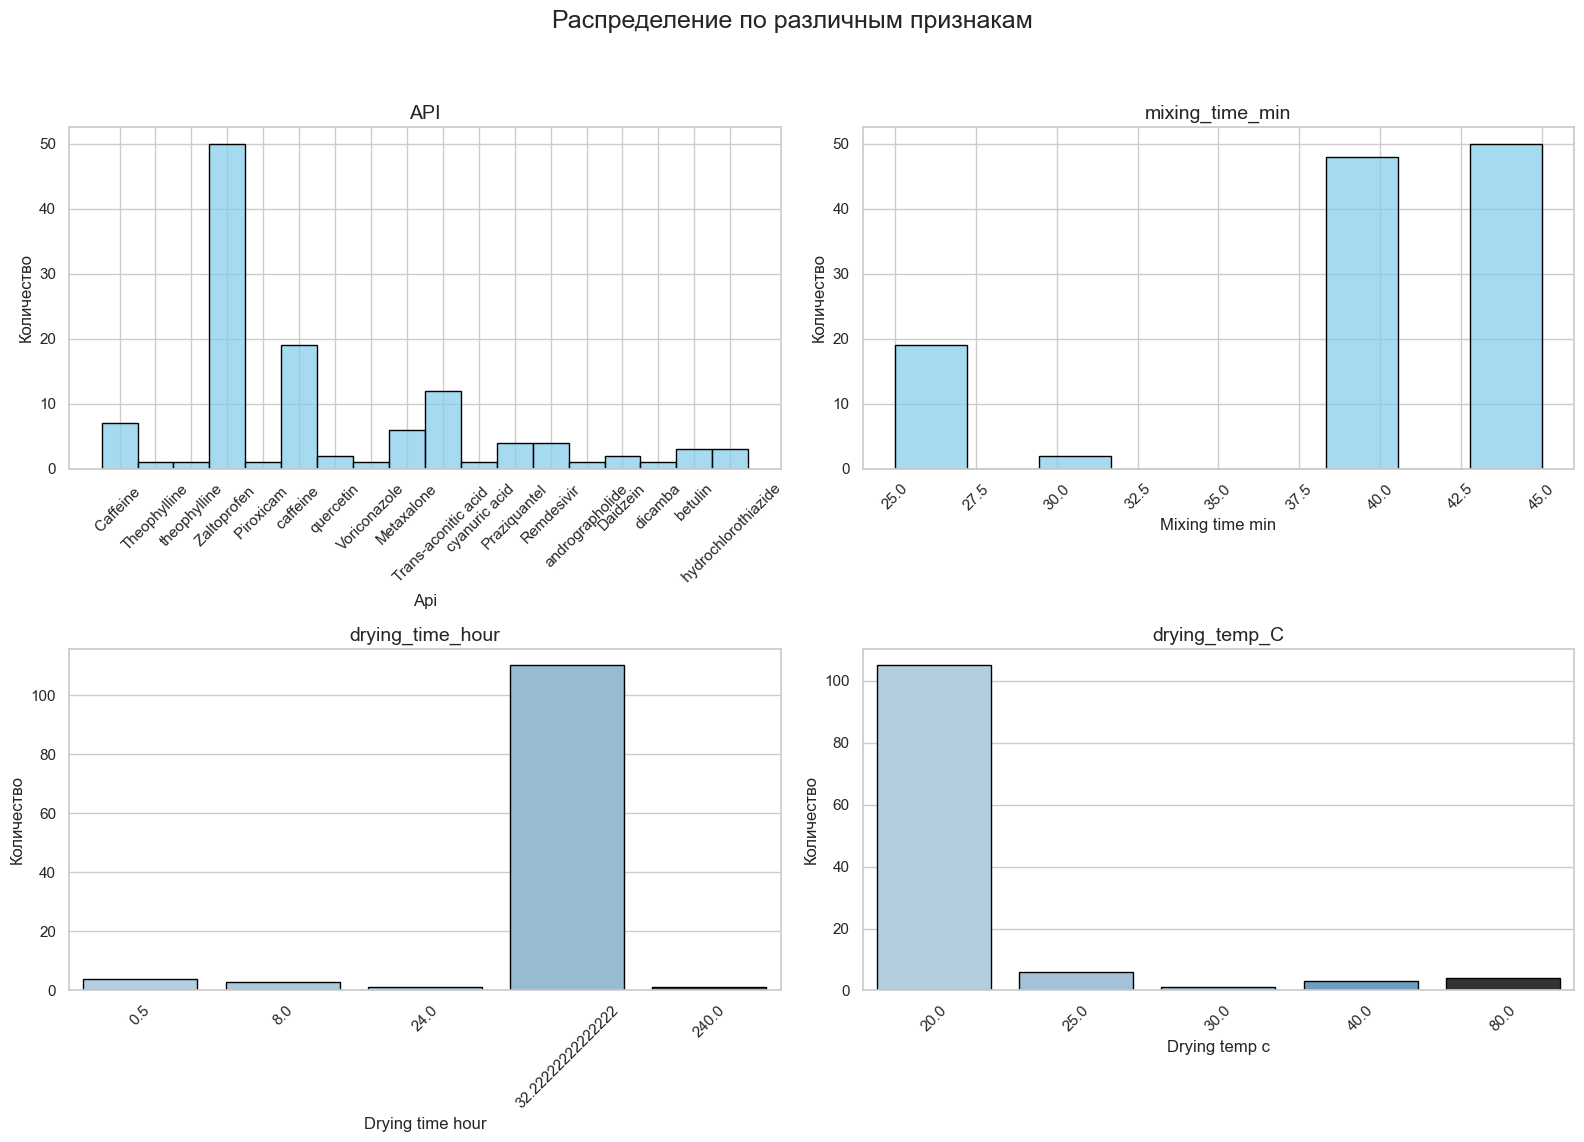

In [37]:
sns.set(style="whitegrid")

df['liq_amount_mL'] = df['liq_amount_mL'].astype('category')

def format_mixing_temp_C(x):
    if isinstance(x, (float, int)):
        return f"{x:.2f}"
    return x

df['mixing_temp_C'] = df['mixing_temp_C'].apply(format_mixing_temp_C).astype('category')

columns = ["API", "mixing_time_min", "drying_time_hour", "drying_temp_C"]
titles = ["API", "mixing_time_min", "drying_time_hour", "drying_temp_C"]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (col, title) in enumerate(zip(columns, titles)):
    if col in ['drying_time_hour', 'drying_temp_C']:
        sns.countplot(
            data=df,
            x=col,
            hue=col,
            palette='Blues_d',
            edgecolor='black',
            ax=axes[i]
        )
        
        if axes[i].get_legend() is not None:
            axes[i].get_legend().remove()
    else:
        sns.histplot(
            data=df,
            x=col,
            kde=False,
            color='skyblue',
            edgecolor='black',
            ax=axes[i]
        )
    
    axes[i].set_title(title, fontsize=14)
    axes[i].set_xlabel(col.replace('_', ' ').capitalize(), fontsize=12)
    axes[i].set_ylabel('Количество', fontsize=12)
    
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle("Распределение по различным признакам", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Анализ категориальных переменных

В этом датасете много категориальных переменных, рассмотрим количество пар АФИ-коформер

In [38]:
df_pie = pd.DataFrame(df.groupby('API')['liq_amount_mL'].count())
df_pie = df_pie.reset_index()
df_pie

,API,liq_amount_mL
0,cyanuric acid,1
1,hydrochlorothiazide,3
2,Caffeine,7
3,Daidzein,2
4,Metaxalone,6
5,Piroxicam,1
6,Praziquantel,4
7,Remdesivir,4
8,Theophylline,1
9,Trans-aconitic acid,12


In [46]:
# Построение круговой диаграммы 
fig = px.pie(df_pie, values="liq_amount_mL", names="API", color_discrete_sequence = colors)  
  
#Вывод графика 
fig.show()

NameError: name 'colors' is not defined

Перед дальнейшим анализом данных, а именно рассмотрением корреляций между данными, их необходимо нормализовать.

Будем использовать MinMax.

In [335]:
# Создадим датафрейм, содержащий только числовые переменные
df_numeric = df.select_dtypes(include=['float64', 'int64'])
df_numeric.head()

,mixing_frequency_Hz,mixing_time_min,drying_time_hour,drying_temp_C
0,39.23,39.225352,32.222222,20.0
1,39.23,39.225352,32.222222,20.0
2,39.23,39.225352,32.222222,20.0
3,39.23,39.225352,32.222222,20.0
4,39.23,39.225352,32.222222,20.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1)) # Создание экземпляра MinMaxScaler с заданным диапазоном

df_numeric_sc = pd.DataFrame(sc.fit_transform(df_numeric), columns=df_numeric.columns) 
df_numeric_sc.head()

,mixing_frequency_Hz,mixing_time_min,drying_time_hour,drying_temp_C
0,1.0,0.711268,0.132452,0.0
1,1.0,0.711268,0.132452,0.0
2,1.0,0.711268,0.132452,0.0
3,1.0,0.711268,0.132452,0.0
4,1.0,0.711268,0.132452,0.0


In [ ]:
# Создание heatmap с использованием Plotly Express
fig = px.imshow(
  df_numeric_sc.corr(),
  color_continuous_scale=colors)

fig.update_layout(
    width=800,  
    height=600  
)

fig.show()

In [41]:
df.to_csv('lag_data_new.csv', index = False)